In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn import model_selection
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, cross_val_score

#Question 1

In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/abalone.csv")

In [0]:
scaler = StandardScaler()

In [4]:
print(data.shape)
data.head()

(4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


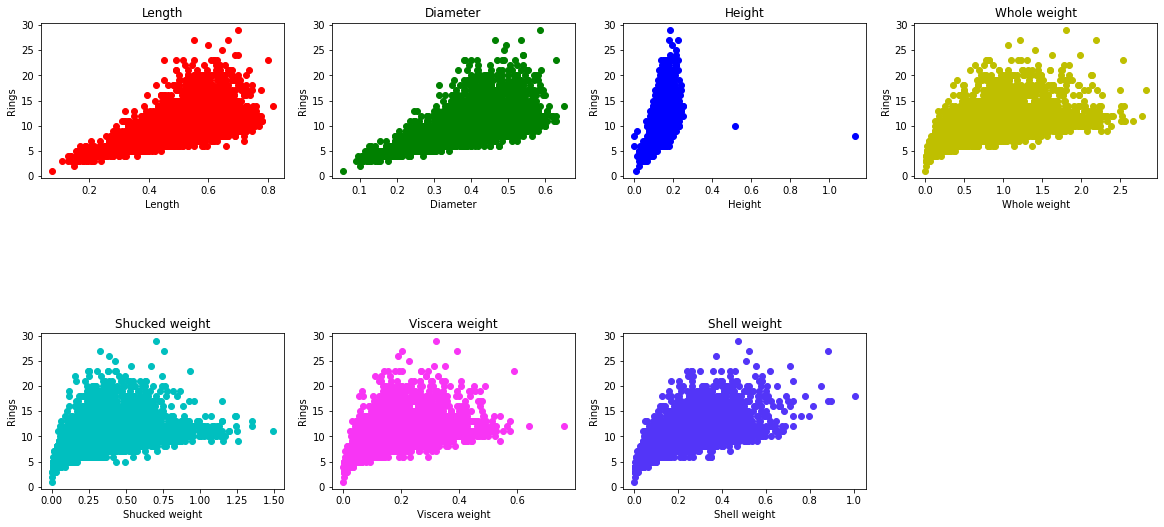

In [7]:
fig = plt.figure(figsize=(20,20))
i=1
colmap = {1:'r', 2:'g', 3:'b', 4:'y', 5:'c', 6:'#F835F5', 7:'#5335F8'}
for col in data.columns:
  if col not in ['Rings','Sex']:
    plt.subplot(4, 4, i)
    plt.title(col)
    plt.scatter(data[col],data['Rings'],color = colmap[i] )
    plt.xlabel(col)
    plt.ylabel('Rings')
    i=i+1

plt.subplots_adjust(hspace=1)
plt.show()

Dividing the dataset into training
and testing (80-20) 

In [0]:
data = data.drop("Sex", axis=1)
X = data.iloc[:,0].values
y = data["Rings"].values
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5) 

In [0]:
def rmse(y_pred, y_act):
 
    n = len(y_act)
    rmse = np.sqrt((np.sum((y_act - y_pred) ** 2) / n)) 

    return rmse 

In [0]:
def gradient_descent(X_train, X_test, y_train, y_test, epochs=10000, alpha=0.01):
  b0 = 0
  b1 = 0

  train_rmse = []
  test_rmse = []

  
  n = len(X_train)

  # gradient descent
  for i in range(epochs):
    y_pred_train = b0*X_train + b1
    y_pred_test = b0*X_test +b1 
    D_b0 = (-2/n) * sum(X_train * (y_train - y_pred_train)) 
    D_b1 = (-2/n) * sum(y_train - y_pred_train)  
    b0 = b0 - alpha * D_b0  
    b1 = b1 - alpha * D_b1 

    train_rmse.append(rmse(y_pred_train, y_train))
    test_rmse.append(rmse(y_pred_test, y_test))

  x = PrettyTable(["b0","b1"])
  x.add_row([b0,b1])
  print(x)
 
  y_pred = b0*X_train + b1
  plt.scatter(X_train, y_train, c='c', label = "scatter plot")
  plt.plot([min(X_train), max(X_train)], [min(y_pred), max(y_pred)], color='red', label = "regression line") # predicted
  plt.ylabel("Rings")
  plt.xlabel("Length")
  plt.title("Linear Regression")
  plt.legend()
  plt.show()

  return train_rmse, test_rmse, rmse(y_pred_train, y_train), rmse(y_pred_test, y_test)    

In [0]:
def gradient_descent_with_regularization(X_train, X_test, y_train, y_test, lmda, epochs=10000, alpha=0.01):
  b0 = 0
  b1 = 0

  train_rmse = []
  test_rmse = []

  
  n = len(X_train)

  # gradient descent
  for i in range(epochs):
    y_pred_train = b0*X_train + b1
    y_pred_test = b0*X_test +b1 
    D_b0 = (-2/n) * sum(X_train * (y_train - y_pred_train)) 
    D_b1 = (-2/n) * sum(y_train - y_pred_train)  
    b0 = b0*(1 - alpha*(lmda/n)) - alpha*D_b0
    b1 = b1*(1 - alpha*(lmda/n)) - alpha*D_b1 

    train_rmse.append(rmse(y_pred_train, y_train))
    test_rmse.append(rmse(y_pred_test, y_test))

  x = PrettyTable(["b0","b1"])
  x.add_row([b0,b1])
  print(x)
  
  print()

  y_pred = b0*X_train + b1
  plt.scatter(X_train, y_train, c='c', label = "scatter plot")
  plt.plot([min(X_train), max(X_train)], [min(y_pred), max(y_pred)], color='red', label = "regression line") # predicted
  plt.ylabel("Rings")
  plt.xlabel("Features")
  plt.title("Linear Regression")
  plt.legend()
  plt.show()

  return train_rmse, test_rmse 


def gradient_descent_normal_form(X_train, X_test, y_train, y_test, epochs, alpha):
    
  theta = np.zeros((X_train.shape[1], 1))
  m = len(X_train)
  train_rmse = []
  test_rmse = []
  y_pred_train = X_train @ theta


  for i in range(epochs):
      theta = theta - (1 / m) * alpha * (X_train.T @ (y_pred_train - y_train))
      y_pred_train = X_train @ theta
      y_pred_test = X_test @ theta

      train_rmse.append(rmse(y_pred_train, y_train))
      test_rmse.append(rmse(y_pred_test, y_test))

  print("Parameters :", *theta)
  print()

  return train_rmse, test_rmse, rmse(y_pred_train, y_train), rmse(y_pred_test, y_test)   

+--------------------+-------------------+
|         b0         |         b1        |
+--------------------+-------------------+
| 6.6283834178646215 | 5.957438807547216 |
+--------------------+-------------------+


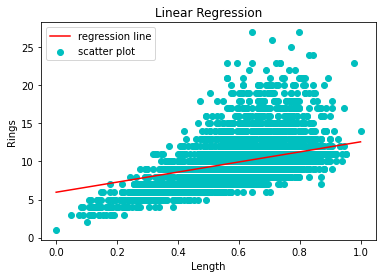

In [12]:
epochs = 10000 # iteration
alpha = 0.001   # learning rate

train_rmse_n, test_rmse_n, train_rmse_k, test_rmse_k = gradient_descent(X_train, X_test, y_train, y_test,epochs,alpha)

**Plots for the root mean squared error (RMSE) vs.
gradient descent iterations for both training as well as testing
set**

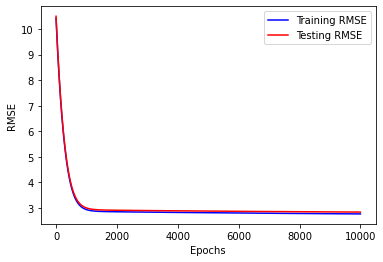

In [13]:
plt.plot(range(epochs), train_rmse_n, c='b', label='Training RMSE')
plt.plot(range(epochs), test_rmse_n, c='r', label='Testing RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

##Normal Equation (closed form) for linear regression

In [0]:
def c_rmse(X, y, theta):
    m = len(X)
    h = X @ theta
    return np.sqrt(np.sum((h - y) ** 2) / m)


def normal_equation(X, y):
    m = len(X)
    theta = ((np.linalg.inv(X.T @ X)) @ X.T) @ y
    h = X @ theta
    return theta

In [0]:
X = data.iloc[:,0].values
y = data['Rings'].values

X = (X-np.min(X))/(np.max(X)-np.min(X))
y = np.reshape(y, (len(y), 1))

one = np.ones(len(X))
X = np.vstack((one, X)).T

Parameters

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_rmse, test_rmse, train_rmse_n, test_rmse_n = gradient_descent_normal_form(X_train, X_test, y_train, y_test, epochs = 10000, alpha = 0.001)

Parameters : [6.5575508] [5.6764643]



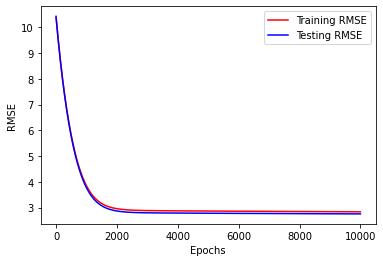

In [17]:
plt.plot(range(epochs), train_rmse, c='r', label='Training RMSE')
plt.plot(range(epochs), test_rmse, c='b', label='Testing RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [0]:
theta = normal_equation(X_train, y_train)
k1 = c_rmse(X_train, y_train, theta)
k2 = c_rmse(X_test, y_test, theta)

**RMSE**

In [19]:
d = [[train_rmse_k, test_rmse_k ], [k1,k2 ] ]
rmse_df = pd.DataFrame(d,index=["gradient descent" ,"Normal equation"], columns=["Training Set", "Testing Set"])
rmse_df

,Training Set,Testing Set
gradient descent,2.758757,2.830493
Normal equation,2.687083,2.641766


#Question 2


In [20]:
data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
X = data.iloc[:,0:1].values
y = data["Rings"].values

scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

**Lasso Regression or L1**

In [0]:
lasso = Lasso(max_iter=10000, random_state=5)

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
tuned_parameters = [{'alpha': alphas }]

n_folds = 5
grid_search = GridSearchCV(estimator = lasso, param_grid= tuned_parameters, cv=n_folds, refit=True)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=False, positive=False,
                             precompute=False, random_state=5,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
grid_search.best_score_

0.3183645939834257

**The optimal regularization parameter for L1**

In [26]:
grid_search.best_params_

{'alpha': 0.0001}

**Hyperparameter**

In [27]:
grid_search.best_estimator_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=5,
      selection='cyclic', tol=0.0001, warm_start=False)

**Ridge Regression or L2**

In [0]:
ridge = Ridge()

In [0]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

grid = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas))

In [30]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
grid.best_score_

0.3183645578900454

**The optimal regularization parameter for L2**

In [32]:
grid.best_params_

{'alpha': 0.01}

Hyperparameter

In [33]:
grid.best_estimator_

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
x = PrettyTable(["Regularization", "Alpha"])
x.add_row(["Lasso or L1", grid_search.best_estimator_.alpha])
x.add_row(["Ridge or L2", grid.best_estimator_.alpha])
print(x)

+----------------+--------+
| Regularization | Alpha  |
+----------------+--------+
|  Lasso or L1   | 0.0001 |
|  Ridge or L2   |  0.01  |
+----------------+--------+


+-------------------+--------------------+
|         b0        |         b1         |
+-------------------+--------------------+
| 6.644185775036808 | 5.9593440592392355 |
+-------------------+--------------------+



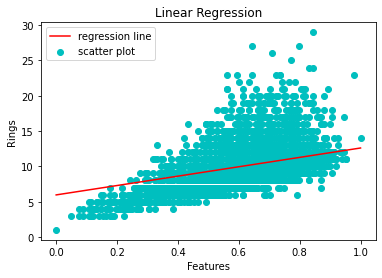

In [35]:
#gradient descent as L1
epochs = 10000 # iteration
alpha = 0.001   # learning rate
lmda = 0.0001

X = data["Length"].values
y = data["Rings"].values
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
train_rmse, test_rmse = gradient_descent_with_regularization(X_train, X_test, y_train, y_test, lmda, epochs, alpha)


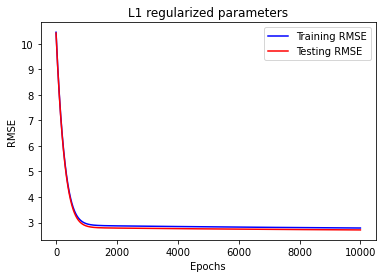

In [36]:
plt.plot(range(epochs), train_rmse, c='b', label='Training RMSE')
plt.plot(range(epochs), test_rmse, c='r', label='Testing RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title("L1 regularized parameters")
plt.legend()
plt.show()

+-------------------+--------------------+
|         b0        |         b1         |
+-------------------+--------------------+
| 6.644151232007547 | 5.9593545637871586 |
+-------------------+--------------------+



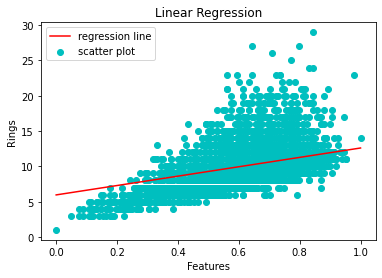

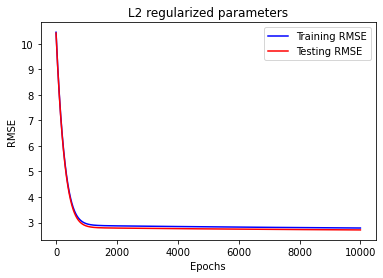

In [37]:
#gradient descent as L2
epochs = 10000 # iteration
alpha = 0.001   # learning rate
lmda = 0.01

X = data["Length"].values

y = data["Rings"].values
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
train_rmse, test_rmse = gradient_descent_with_regularization(X_train, X_test, y_train, y_test,lmda ,epochs, alpha)

plt.plot(range(epochs), train_rmse, c='b', label='Training RMSE')
plt.plot(range(epochs), test_rmse, c='r', label='Testing RMSE')
plt.title("L2 regularized parameters")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#Question 3

B0 =  325.57342104944223
B1 =  0.26342933948939945



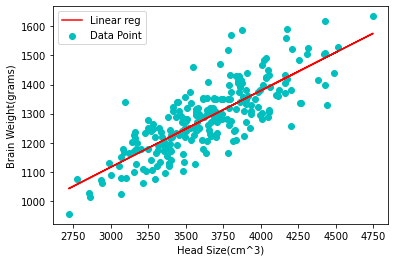

RMSE : 72.1206213783709


In [38]:
df = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/headbrain.csv").drop(["Gender","Age Range"], axis=1)

X = df["Head Size(cm^3)"].values
y = df["Brain Weight(grams)"].values

X_mean = np.mean(X)
Y_mean = np.mean(y)
n = len(X)

num = 0
den = 0
for i in range(n):
    num += (X[i]-X_mean) * (y[i] - Y_mean)
    den += (X[i]-X_mean) ** 2

B1 = num/den
B0 = Y_mean - B1 * X_mean
print("B0 = ",B0)
print("B1 = ",B1)
print()

x_min = np.min(X)
x_max = np.max(X)


y_pred_linear = B1 * X + B0

plt.scatter(X,y ,color = 'c' ,label = "Data Point")
plt.plot(X,y_pred_linear ,color = 'r' , label = "Linear reg")
plt.xlabel("Head Size(cm^3)")
plt.ylabel("Brain Weight(grams)")
plt.legend()
plt.show()

print("RMSE :",rmse(y, y_pred_linear))

**Ridge Regression**

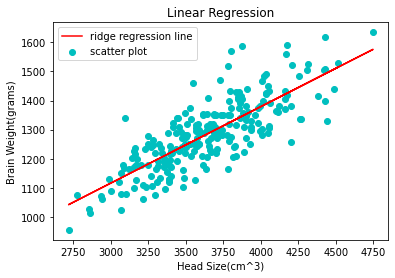


{'alpha': 1e-08}
RMSE : 72.1206213783709


In [39]:
ridge = Ridge()
X = X.reshape((len(X),1))
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5,)
ridge_regressor.fit(X, y)
y_pred_ridge = ridge_regressor.predict(X)

plt.scatter(X, y, c='c', label = "scatter plot")
plt.plot(X,y_pred_ridge,color="red", label= "ridge regression line")
plt.ylabel("Brain Weight(grams)")
plt.xlabel("Head Size(cm^3)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print()
print(ridge_regressor.best_params_)

print("RMSE :",rmse(y, y_pred_ridge))

**Lasso Regression**

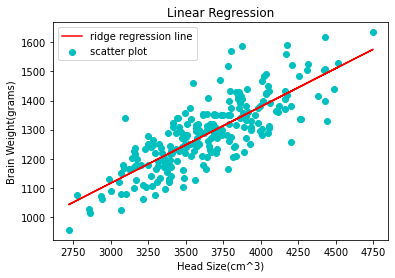


{'alpha': 1e-10}
RMSE : 72.1206213783709


In [40]:
lasso = Lasso()
X = X.reshape((len(X),1))

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters,scoring='neg_mean_squared_error', cv=5,)
lasso_regressor.fit(X, y)
y_pred_lasso = lasso_regressor.predict(X)


plt.scatter(X, y, c='c', label = "scatter plot")
plt.plot(X,y_pred_lasso,color="red", label= "ridge regression line")
plt.ylabel("Brain Weight(grams)")
plt.xlabel("Head Size(cm^3)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print()
print(lasso_regressor.best_params_)

print("RMSE :",rmse(y, y_pred_lasso))


**Applying gradient descent **

+-------------------+--------------------+
|         b0        |         b1         |
+-------------------+--------------------+
| 517.9837045862431 | 1052.2577047959705 |
+-------------------+--------------------+


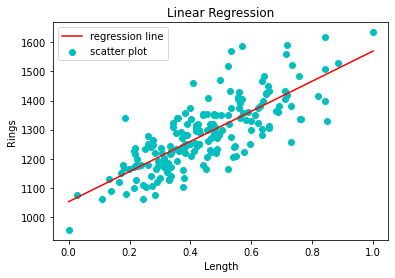

In [41]:
#applying gradient descent
X = df["Head Size(cm^3)"].values
y = df["Brain Weight(grams)"].values
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
train_rmse, test_rmse , t_train_rmse, t_test_rmse = gradient_descent(X_train, X_test, y_train, y_test,epochs=10000,alpha=0.01)

+-------------------+-------------------+
|         b0        |         b1        |
+-------------------+-------------------+
| 517.9837045460068 | 1052.257704786054 |
+-------------------+-------------------+



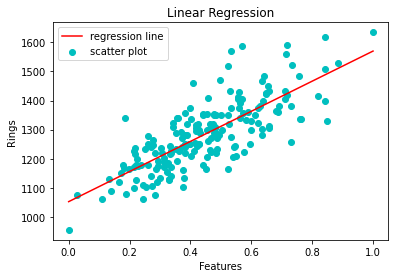

In [42]:
epochs = 10000 # iteration
alpha = 0.01   # learning rate
lmda=1e-08

train_rmse, test_rmse = gradient_descent_with_regularization(X_train, X_test, y_train, y_test,lmda,epochs,alpha)

+-------------------+-------------------+
|         b0        |         b1        |
+-------------------+-------------------+
| 517.9837045859362 | 1052.257704795823 |
+-------------------+-------------------+



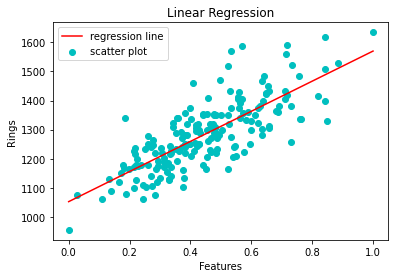

In [43]:
epochs = 10000 # iteration
alpha = 0.01   # learning rate
lmda=1e-10

train_rmse, test_rmse = gradient_descent_with_regularization(X_train, X_test, y_train, y_test,lmda,epochs,alpha)